# Gaussian experiment
All data is generated on the fly

In [4]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *
import scipy.stats
import os
import sobol
import resource
import json

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


# Setup

In [5]:
def generate_sobol_points(M, dim):
    points = []
    for i in range(M):
        points.append(sobol.i4_sobol(dim,i)[0])
    return np.array(points)

dims = [6]
dim = 6
M = int(2**20)

data_sources = {}
for dim in dims: 
    #data_sources["Monte Carlo %d dims" % dim] =  np.random.uniform(0, 1, (M,dim))
    data_sources["QMC Sobol %d dims" % dim] = generate_sobol_points(M, dim)
    #data_sources["MC Normal %d dims" % dim] = np.random.normal(0,1, (M, dim))
    

def sine_functional(x):
    return np.sum(np.sin(4*np.pi*x), 1)
def normal_functional(x):
    return scipy.stats.norm.ppf(x)

def sum_functional(x):
    return np.sum(x, 1)
def square_functional(x):
    return np.sum(x**2, 1)

def circle_functional(x):
    return np.sum((x-0.5)**4, 1)

functionals = {"Circle" : circle_functional,
               "Sine" : sine_functional,
                "Square": square_functional,
               "Sum": sum_functional,
               "Sine Normal" : lambda x : sine_functional(normal_functional(x)),
               "Sum Normal" : lambda x: sum_functional(normal_functional(x))
               }

network_width = 12
network_depth = 10
    
gaussian_network =  [network_width for k in range(network_depth)]
gaussian_network.append(1)

epochs = 500000

print(gaussian_network)
console_log(gaussian_network)


[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1]


In [ ]:

optimizers = {"SGD": keras.optimizers.SGD,
                 "Adam": keras.optimizers.Adam}
    
losses = ["mean_squared_error"]

for data_source_name in data_sources.keys():
   
    for functional_name in functionals.keys():
        title = '%s_%s' % (data_source_name, functional_name)
        display(HTML("<h1>%s</h1>" % title))
        for optimizer in optimizers.keys():
            for loss in losses:
                tables = Tables.make_default()
                parameters = data_sources[data_source_name]
                samples = functionals[functional_name](parameters)
                showAndSave.silent=True
                print_comparison_table.silent = True
                network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                             network=gaussian_network, train_size=128,
                                                             validation_size=128,
                                                            loss=loss, tries=5)
                    
                output_information = OutputInformation(tables=tables, title=title,
                                                          short_title=title)
                
                def run_function(network_information, output_information):
                    showAndSave.prefix='convergence_%s_%s_%s_ts_%d' %(title, optimizer, loss, network_information.train_size)
                    get_network_and_postprocess(parameters, samples, network_information = network_information,
                        output_information = output_information)
                
                    showAndSave.prefix='convergence_%s_%s_%s_all' %(title, optimizer, loss)
                    
                plot_train_size_convergence(network_information,
                               output_information, 
                               run_function,
                               samples.shape[0]//128
                               )


Training took 1895.142275094986 seconds

Training took 2099.1862144470215 seconds

Training took 1483.4844615459442 seconds

Training took 988.3106849193573 seconds

Training took 965.545695066452 seconds
Best network index: 4
Total learning time took: 7474 s
Training took 973.94220662117 seconds
Number of parameters: 1501
(1048576,)
(1048576, 6)
Memory usage: 1430244
Memory usage: 1430244
Memory usage: 1430244

Training took 717.5242495536804 seconds

Training took 761.9521384239197 seconds

Training took 813.2535524368286 seconds

Training took 849.1145102977753 seconds

Training took 906.9856832027435 seconds
Best network index: 2
Total learning time took: 4090 s
Training took 915.9128575325012 seconds
Number of parameters: 1501
(1048576,)
(1048576, 6)
Memory usage: 2110972
Memory usage: 2110972
Memory usage: 2110972

Training took 974.5467457771301 seconds

Training took 1037.9365673065186 seconds

Training took 1125.2015886306763 seconds

Training took 1182.1572480201721 seconds


# Training setup

In [3]:
def train(*, parameters, samples, title):
    train_sizes = 2**np.arange(5, 13)#[ 128, 512, 1024, 20]
    
    optimizers = {"SGD": keras.optimizers.SGD,
                 "Adam": keras.optimizers.Adam}
    
    losses = ["mean_squared_error"]
    
    for optimizer in optimizers.keys():
        for loss in losses:
            display(HTML("<h1>{}: Computed with {} with {}</h1>".format(title, optimizer, loss)))
            prediction_errors = []
            print_comparison_table.silent = True
            showAndSave.silent = True
            for train_size in train_sizes:
                print(train_size)
                tables = Tables.make_default()
                batch_size = train_size
                validation_size=train_size
                
                
                
                network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                             network=gaussian_network, train_size=train_size,
                                                             validation_size=validation_size,
                                                            loss=loss, tries=1)
                    
                output_information = OutputInformation(tables=tables, title=title,
                                                          short_title=title)
                showAndSave.prefix='%s_%s_%s_ts_%d_bs_%d' %(title, optimizer, loss, batch_size, train_size)
                get_network_and_postprocess(parameters, samples, network_information = network_information,
                        output_information = output_information)
                
                showAndSave.prefix='%s_%s_%s_all_ts_%d_bs_%d' %(title, optimizer, loss, batch_size, train_size)
                tables.write_tables()
                prediction_errors.append(output_information.prediction_error[2])
            showAndSave.silent=False
            plt.loglog(train_sizes, prediction_errors, '-*', label='$L^2$ error')
            plt.xlabel('Training size')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(('Training loss as a function of training samples\n' + \
                      'Loss: {loss}, optimizer: {optimizer},\n{title}').format(loss=loss, optimizer=optimizer, 
                                                                               title=title))
            showAndSave.prefix='%s_%s_%s_all_ts_%d_bs' %(title, optimizer, loss, batch_size)
            showAndSave('training_loss_size')
            

# Training

32

Training took 54.047518730163574 seconds
Best network index: 0
Total learning time took: 57 s
Training took 57.727651834487915 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 451068
Memory usage: 451068
Memory usage: 451068
64

Training took 52.24051809310913 seconds
Best network index: 0
Total learning time took: 55 s
Training took 55.831400871276855 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 566708
Memory usage: 566708
Memory usage: 566708
128

Training took 60.353604555130005 seconds
Best network index: 0
Total learning time took: 63 s
Training took 64.10992550849915 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 744680
Memory usage: 744680
Memory usage: 744680
256

Training took 76.15464878082275 seconds
Best network index: 0
Total learning time took: 79 s
Training took 80.1576087474823 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 827700
Memory usage: 827700
Memory usage: 827700
512

Tr

/usr/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: invalid value encountered in less
  xmin = min(xmin, xi.min())
/usr/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: invalid value encountered in greater
  xmax = max(xmax, xi.max())


max must be larger than min in range parameter.
Memory usage: 1050420
Memory usage: 1050420
Memory usage: 1050420
2048

Training took 262.59585523605347 seconds
Best network index: 0
Total learning time took: 266 s
Training took 267.0040371417999 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1062860
Memory usage: 1062860
Memory usage: 1062860
4096

Training took 442.98562121391296 seconds
Best network index: 0
Total learning time took: 446 s
Training took 446.8513822555542 seconds
Number of parameters: 1501
(32768,)
(32768, 6)


/usr/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: invalid value encountered in less
  xmin = min(xmin, xi.min())
/usr/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: invalid value encountered in greater
  xmax = max(xmax, xi.max())


max must be larger than min in range parameter.
Memory usage: 1082872
Memory usage: 1082872
Memory usage: 1201492


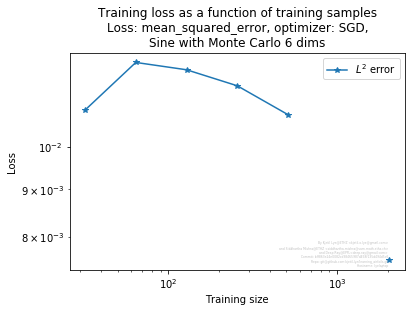

32

Training took 73.97617983818054 seconds
Best network index: 0
Total learning time took: 78 s
Training took 78.94977164268494 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1237432
Memory usage: 1237432
Memory usage: 1237432
64

Training took 80.86577343940735 seconds
Best network index: 0
Total learning time took: 84 s
Training took 85.24812531471252 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1237432
Memory usage: 1237432
Memory usage: 1237432
128

Training took 89.62639212608337 seconds
Best network index: 0
Total learning time took: 93 s
Training took 94.40592670440674 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1237432
Memory usage: 1237432
Memory usage: 1237432
256

Training took 101.74689245223999 seconds
Best network index: 0
Total learning time took: 106 s
Training took 106.50140738487244 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1237432
Memory usage: 1237432
Memory usage: 123

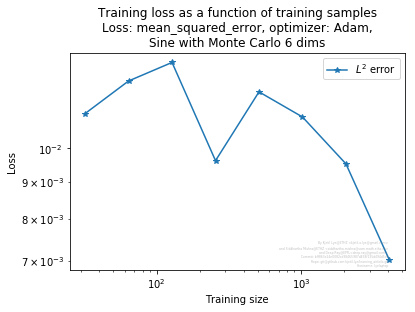

32

Training took 99.62602925300598 seconds
Best network index: 0
Total learning time took: 105 s
Training took 105.62526059150696 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1468308
Memory usage: 1468308
Memory usage: 1468308
64

Training took 133.9204704761505 seconds
Best network index: 0
Total learning time took: 140 s
Training took 141.67187547683716 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1468308
Memory usage: 1468308
Memory usage: 1468308
128

Training took 141.1093647480011 seconds
Best network index: 0
Total learning time took: 145 s
Training took 146.53985857963562 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1468308
Memory usage: 1468308
Memory usage: 1468308
256

Training took 121.99109363555908 seconds
Best network index: 0
Total learning time took: 126 s
Training took 127.21374607086182 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1468308
Memory usage: 1468308
Memory usag

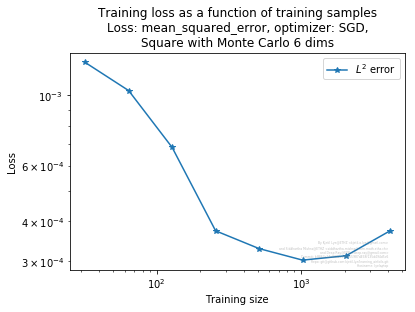

32

Training took 153.68794894218445 seconds
Best network index: 0
Total learning time took: 159 s
Training took 160.94251227378845 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1537416
Memory usage: 1537416
Memory usage: 1537416
64

Training took 178.24978590011597 seconds
Best network index: 0
Total learning time took: 183 s
Training took 184.4909827709198 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1537416
Memory usage: 1537416
Memory usage: 1537416
128

Training took 194.73013257980347 seconds
Best network index: 0
Total learning time took: 200 s
Training took 201.055189371109 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1537416
Memory usage: 1537416
Memory usage: 1537416
256

Training took 247.05904579162598 seconds
Best network index: 0
Total learning time took: 252 s
Training took 253.18448686599731 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1537416
Memory usage: 1537416
Memory usag

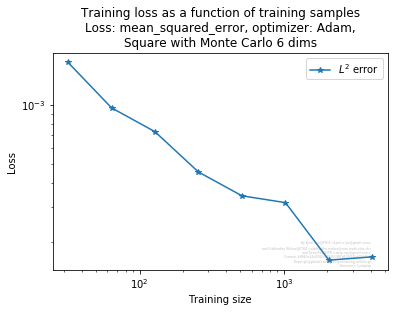

32

Training took 193.81264185905457 seconds
Best network index: 0
Total learning time took: 199 s
Training took 201.43068552017212 seconds
Number of parameters: 1501
(32768,)
(32768, 6)
Memory usage: 1650196
Memory usage: 1650196
Memory usage: 1650196
64


KeyboardInterrupt: 

In [4]:
for data_source_name in data_sources.keys():
   
    for functional_name in functionals.keys():
        parameters = data_sources[data_source_name]
        functional = functionals[functional_name]
        
        samples = functional(parameters)
        title = '{} with {}'.format(functional_name, data_source_name)
        
        train(parameters=parameters, samples=samples, title=title)
   